In [50]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [51]:
traj = xr.open_dataset("/home/kbrennan/balloon_optimizer/lagranto/trajectory.4")

In [52]:
traj = traj.squeeze()

# fix time (time is now in hours.minutes, convert to decimal hours)
time = traj.time.values
hours = np.floor(time)
minutes = (time - hours) * 100
decimal_time = hours + minutes / 60
traj['time'] = decimal_time

# terminate trajectory (override with nan) that reaches the ground (p within 1 hPa of PS)

# find first ground-contact index (per trajectory) where p is within 1 hPa of PS
p = traj['p']
ps = traj['PS']
ground_contact = np.abs(p - ps) <= 1.0

has_contact = ground_contact.any(dim='time')
first_contact_index = ground_contact.argmax(dim='time')
n_time = traj.sizes['time']
first_contact_index = xr.where(has_contact, first_contact_index, n_time)

# build a time index array and broadcast to full trajectory shape
time_idx = xr.DataArray(
    np.arange(n_time),
    dims=('time',),
    coords={'time': traj['time']}
 )
time_idx_broadcast, _ = xr.broadcast(time_idx, p)
first_contact_broadcast = first_contact_index.broadcast_like(p)

# mask points strictly after first ground contact
mask_after_ground = time_idx_broadcast > first_contact_broadcast

# apply mask to all trajectory variables that have a dimx_lon dimension
for var_name, da in traj.data_vars.items():
    if 'dimx_lon' in da.dims:
        traj[var_name] = da.where(~mask_after_ground)

In [53]:
traj

<xarray.Dataset> Size: 466kB
Dimensions:   (time: 421, dimx_lon: 27, dimx_BASEDATE: 6)
Coordinates:
  * time      (time) float32 2kB 0.0 -2.0 -1.167 -1.0 ... 67.5 67.67 67.83 68.0
Dimensions without coordinates: dimx_lon, dimx_BASEDATE
Data variables:
    lon       (time, dimx_lon) float32 45kB 7.431 7.691 ... -0.2861 0.01664
    lat       (time, dimx_lon) float32 45kB 51.36 51.37 51.36 ... 36.78 36.74
    p         (time, dimx_lon) float32 45kB 836.4 843.5 845.5 ... 839.2 837.6
    T         (time, dimx_lon) float32 45kB 275.5 274.8 274.9 ... 288.1 288.3
    LWC       (time, dimx_lon) float32 45kB 0.01779 0.036 0.05316 ... 0.0 0.0
    IWC       (time, dimx_lon) float32 45kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    RWC       (time, dimx_lon) float32 45kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SWC       (time, dimx_lon) float32 45kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PS        (time, dimx_lon) float32 45kB 1.009e+03 1.004e+03 ... 1.012e+03
    balloon   (time, dimx_lon) float32 45kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    BASEDATE  (time, dimx_BASEDATE) float32 10kB ...
Attributes:
    domxmin:              0.0
    domxmax:              0.0
    domymin:              0.0
    domymax:              0.0
    domzmin:              0.0
    domzmax:              0.0
    constants_file_name:  trajectory.4_cst

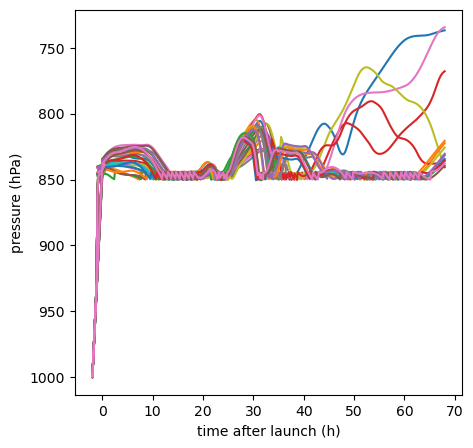

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(traj.time, traj.p)
ax.set_ylabel('pressure (hPa)')
ax.set_xlabel('time after launch (h)')
ax.invert_yaxis()

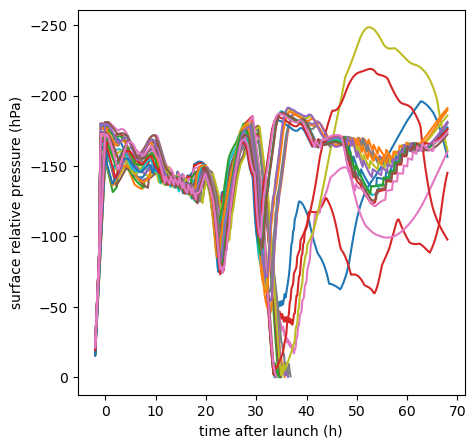

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(traj.time, traj.p-traj.PS)
ax.set_ylabel('surface relative pressure (hPa)')
ax.set_xlabel('time after launch (h)')
ax.invert_yaxis()


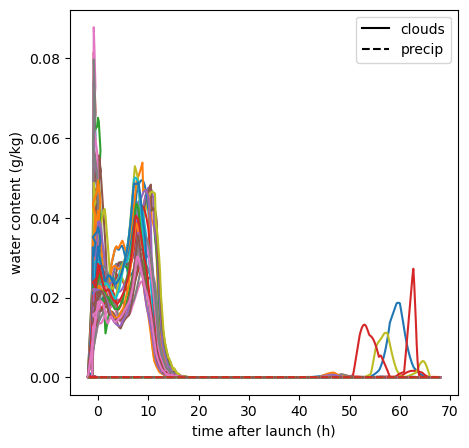

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(traj.time, traj.IWC+traj.LWC, '-')
ax.plot(traj.time, traj.RWC+traj.SWC, '--')
ax.set_ylabel('water content (g/kg)')
ax.set_xlabel('time after launch (h)')
ax.plot([], [], '-', color='black', label='clouds')
ax.plot([], [], '--', color='black', label='precip')
ax.legend()

/home/kbrennan/.conda/envs/kbrennan_2024/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/kbrennan/.conda/envs/kbrennan_2024/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/kbrennan/.conda/envs/kbrennan_2024/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/kbrennan/.conda/envs/kbrennan_2024/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/kbrennan/.conda/envs/kbrennan_2024/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords,

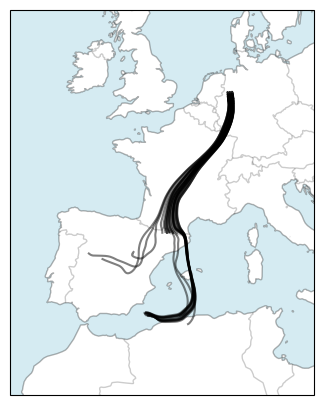

In [57]:
projection_center = (traj.lon.mean().values, traj.lat.mean().values)
padding = 5
projection = ccrs.RotatedPole(pole_longitude=projection_center[0]-180, pole_latitude=90-projection_center[1])
fig, ax = plt.subplots(1, 1, figsize=(5,5), subplot_kw={'projection': projection})
ax.coastlines(alpha=0.3)
ax.add_feature(ccrs.cartopy.feature.OCEAN, facecolor='lightblue',alpha=0.5)
ax.add_feature(ccrs.cartopy.feature.BORDERS, alpha=0.2)

ax.plot(traj.lon, traj.lat, '-k', transform=ccrs.PlateCarree(), alpha=0.5)

ax.set_extent([traj.lon.min() - padding, traj.lon.max() + padding, traj.lat.min() - padding, traj.lat.max() + padding], crs=ccrs.PlateCarree())